
# Stylométrie et datation (UniGE, 26.04.2024)

Modèle basé sur: 

Fast Stylometry model for Burrows' Delta
By [Thomas Wood](https://freelancedatascientist.net), [Fast Data Science](https://fastdatascience.com)

Burrows' Delta est un algorithme pour comparer la similitude entre plusieurs textes, connu aussi comme [forensic stylometry](https://fastdatascience.com/how-you-can-identify-the-author-of-a-document/).

* [Une explication du Burrows' Delta et comment ça marche](https://programminghistorian.org/en/lessons/introduction-to-stylometry-with-python#third-stylometric-test-john-burrows-delta-method-advanced)

Demonstration du Burrows' Delta avec un petit corpus de contes et nouvelles écrits par des auteur.trice.s argentin.e.s du XXe siècle:

Horacio Quiroga (1878-1937)

Jorge Luis Borges (1899-1986)

Silvina Ocampo (1903-1993)

Adolfo Bioy Casares (1914-1999)

Julio Cortázar (1914-1984)



Nous allons tester le Burrows' Delta sur deux textes: "El Aleph", publié par Jorge Luis Borges (marqué avec un x), et "Las doce figuras del mundo", écrit en collaboration par ce même auteur et Adolfo Bioy Casares, mais publié sur le pseudonyme de H. Bustos Domecq.



## I. Installation de la librairie Fast Stylometry

In [28]:
!pip install faststylometry


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
from faststylometry import Corpus

from faststylometry import download_examples
from faststylometry import load_corpus_from_folder
from faststylometry import tokenise_remove_pronouns_en
from faststylometry import calculate_burrows_delta
from faststylometry import predict_proba, calibrate, get_calibration_curve
from pandas.core.computation.check import NUMEXPR_INSTALLED

# II. Charger les données dans la Fast Stylometry library.

In [7]:
# Charger le corpus

train_corpus = load_corpus_from_folder("data/train")

# Tokeniser les textes

train_corpus.tokenise(tokenise_remove_pronouns_en)

# III. Charger deux textes d'auteurs "inconnus" pour tester l'algorithme

In [8]:
# Charger "El Aleph", écrit par Jorge Luis Borges (marqué comme "x_-_aleph")
# Et "Las doce figuras del mundo", écrit en collaboration par Jorge Luis Borges et Adolfo Bioy Casares, sous le pseudonyme de H. Bustos Domecq (marqué comme "bustosdomecq_-_doce_figuras_mundo")

test_corpus = load_corpus_from_folder("data/test", pattern=None)

# On tokenise les textes.

test_corpus.tokenise(tokenise_remove_pronouns_en)

# IV. Calculer le Burrows' Delta pour les deux textes d'auteurs "inconnus"

In [9]:
calculate_burrows_delta(train_corpus, test_corpus, vocab_size = 50)

,bustosdomecq - doce_figuras_mundo,x - aleph
bioy,0.999367,1.220068
borges,1.030605,0.919021
cortazar,1.076991,1.367532
ocampo,1.265872,1.171968
quiroga,1.228035,1.358392


# V. Calibrer le modèle et calculer la probabilité de chaque candidat d'être l'auteur "inconnu"

In [10]:
calibrate(train_corpus)

In [11]:
predict_proba(train_corpus, test_corpus)

,bustosdomecq - doce_figuras_mundo,x - aleph
bioy,0.665866,0.598732
borges,0.656693,0.688879
cortazar,0.642854,0.551528
ocampo,0.584223,0.613785
quiroga,0.596220,0.554491


# VI. Courbes du modèle

In [12]:
import numpy as np
x_values =  np.arange(0, 3, 0.1)

import matplotlib.pyplot as plt

''

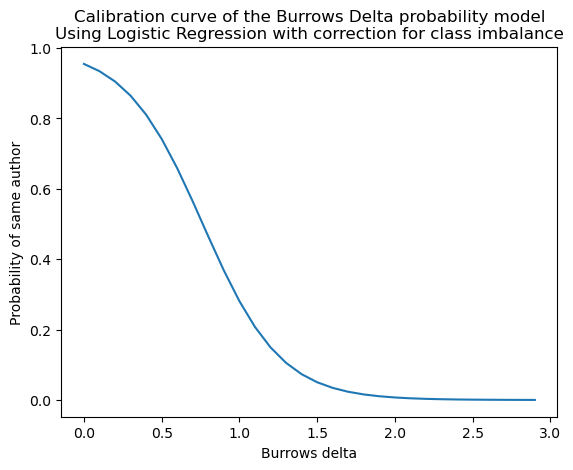

In [9]:
plt.plot(x_values, train_corpus.probability_model.predict_proba(np.reshape(x_values, (-1, 1)))[:,1])
plt.xlabel("Burrows delta")
plt.ylabel("Probability of same author")
plt.title("Calibration curve of the Burrows Delta probability model\nUsing Logistic Regression with correction for class imbalance")
;

# Courbe ROC (performance)


In [13]:
ground_truths, deltas = get_calibration_curve(train_corpus)

In [14]:
probabilities = train_corpus.probability_model.predict_proba(np.reshape(deltas, (-1, 1)))[:,1]

In [15]:
from sklearn.metrics import roc_curve, auc

In [16]:
fpr, tpr, thresholds = roc_curve(ground_truths, probabilities)

In [17]:
roc_auc = auc(fpr, tpr)

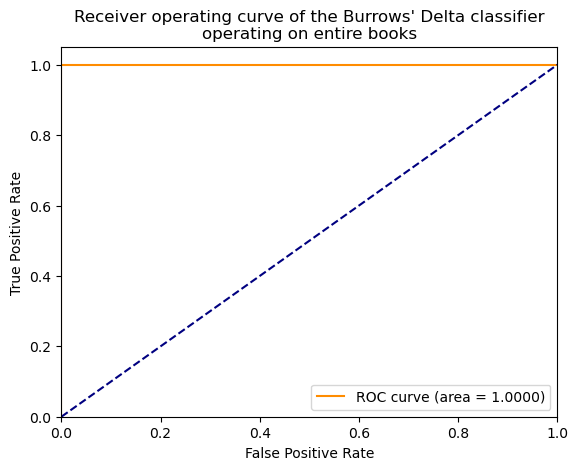

In [15]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve of the Burrows\' Delta classifier\noperating on entire books')
plt.legend(loc="lower right")
plt.show()

# VII. Segmenter le corpus et disposer les textes dans un graphique 2D des similarités stylistiques


In [18]:
from sklearn.decomposition import PCA
import re
import pandas as pd

In [19]:
# Reload the training corpus as the "test corpus", re-tokenise it, and segment it this time
test_corpus = load_corpus_from_folder("data/train")
test_corpus.tokenise(tokenise_remove_pronouns_en)

In [20]:
split_test_corpus = test_corpus.split(80000)

In [21]:
df_delta = calculate_burrows_delta(train_corpus, split_test_corpus)

In [22]:
z_scores = split_test_corpus.author_z_scores

In [23]:
pca_model = PCA(n_components=2)

In [24]:
pca_matrix = pca_model.fit_transform(z_scores.T)

In [25]:
authors = split_test_corpus.authors

In [26]:
df_pca_by_author = pd.DataFrame(pca_matrix)
df_pca_by_author["author"] = authors

Text(0.5, 1.0, 'Representation using PCA of works in training corpus')

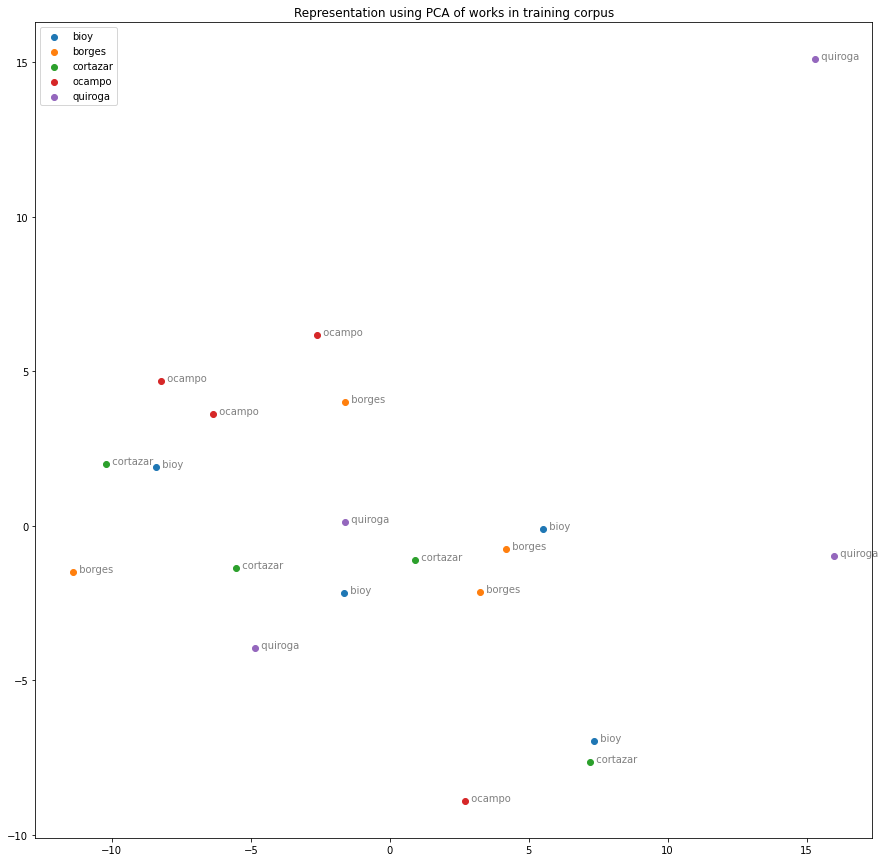

In [27]:
plt.figure(figsize=(15,15)) 

for author, pca_coordinates in df_pca_by_author.groupby("author"):
    plt.scatter(*zip(*pca_coordinates.drop("author", axis=1).to_numpy()), label=author)
for i in range(len(pca_matrix)):
    plt.text(pca_matrix[i][0], pca_matrix[i][1],"  " + authors[i], alpha=0.5)

plt.legend()

plt.title("Representation using PCA of works in training corpus")